# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> One can mention the Kullback-Leibler Divergence which measures dissimilarity between probability distributions and is used as training criterion for VAEs and Normalizing Flows. In Transportation Theory, the Monge and Kantorovitch problem introduces a loss function between a probability distribution and the push forward image of another. The Jensen-Shannon Divergence is used as a similarity measure to train DCGANs.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> On one hand, models

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses. 

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> Intuitively, the higher the input dimension $N$ is, the more complex the mapping function $f_\theta$ will be. Consider $M$ the dimension of the output space. In most cases, the target data is not a general representation of the output space. Indeed, most of its information will be contained in a smaller subspace of dimension $M_{real} \leq M$. We can hope for our model to generate data from this subspace at best, as it will be learned from the target data. 
* An intuition would be to choose $N=M_{real}$. In this case, input data is sampled in the same dimension space as the target data and $f_\theta$ is a bijection from $\mathbb{R}^{M_{real}}$ into itself.
* Choosing $N<M_{real}$ samples data from a smaller space and will make it difficult for the model to generalize to the whole dataset. The smaller $N$ is, the less diversity there will be in our generated samples.
* Choosing $N>M_{real}$ samples the data from a space of higher dimension and will lead to overcomplexifying the model. Training will be more difficult and could lead to overfitting.


By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> Computing the $JSD$ requires to have access to $p_\theta$ and $p_D$. But, as stated above, unless strong assumptions are made on $f_\theta$, the generator structure does not allow to compute $p_\theta$. Moreover, $p_D$ is, by formulation of the problem, a measure we do not have access to. Thus $JSD$ is impossible to compute.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> Not only does this loss allow for the generator to learn from its mistakes, but it also allows the generator to learn from its successes. Consider the case where only one of the generated points confuses the discrimator. The generator will then try to learn to reproduce that point. After a few epochs of training, this may lead the generator to converge to this single point. Once the discriminator is retrained, it will learn to predict that this point is generated. The generator will then have to take large steps outside of the local maxima it trained into and find new confusing points for the discriminator and so on.

> This problem is commonly referred to as **Mode Collapse**.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [6]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

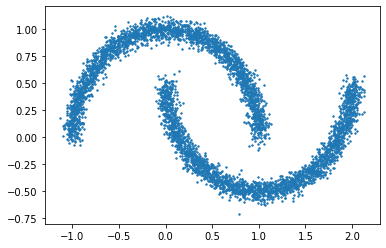

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        self.module_list = nn.ModuleList()
        self.module_list.append(nn.Linear(PRIOR_N,neurons[0]))
        for i in range(len(neurons[1:])):
            self.module_list.append(nn.Linear(neurons[i],neurons[i+1]))
        
    def __call__(self, z):
        for layer in self.module_list[:-1]:
            z = nn.ReLU()(layer(z))
        z  = self.module_list[-1](z)
        return z
    
    def generate(self, batchlen, device):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0).to(device)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        self.module_list = nn.ModuleList()
        self.module_list.append(nn.Linear(2,neurons[0]))
        for i in range(len(neurons)-1):
            self.module_list.append(nn.Linear(neurons[i],neurons[i+1]))
    
    def __call__(self, x):
        for layer in self.module_list[:-1]:
            x = nn.ReLU()(layer(x))
        x = nn.Sigmoid()(self.module_list[-1](x))
        return x

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.279e+00, generator: 7.112e-01


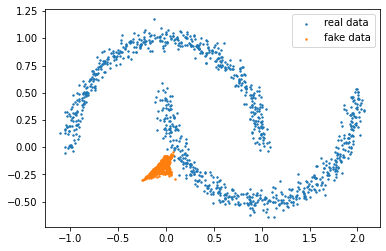

step 1000: discriminator: 1.138e+00, generator: 9.406e-01


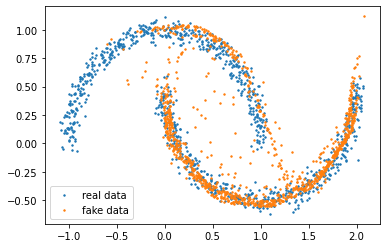

step 2000: discriminator: 1.233e+00, generator: 9.177e-01


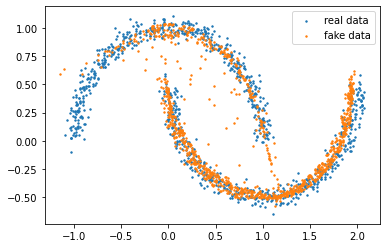

step 3000: discriminator: 1.185e+00, generator: 8.818e-01


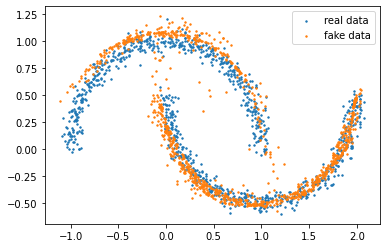

step 4000: discriminator: 1.294e+00, generator: 8.739e-01


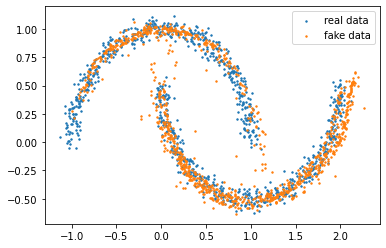

step 5000: discriminator: 1.279e+00, generator: 8.371e-01


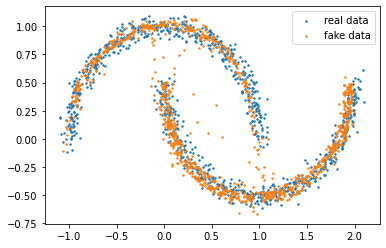

step 6000: discriminator: 1.363e+00, generator: 7.424e-01


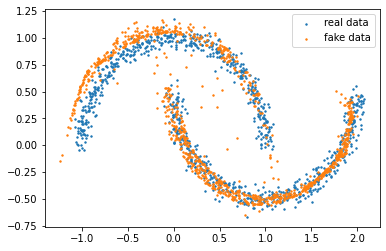

step 7000: discriminator: 1.307e+00, generator: 7.452e-01


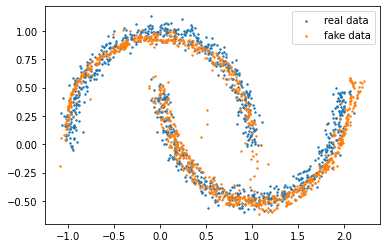

step 8000: discriminator: 1.352e+00, generator: 7.595e-01


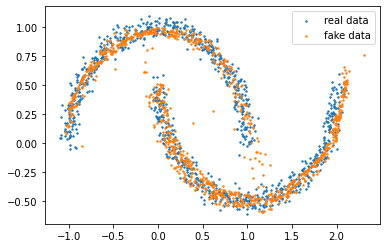

step 9000: discriminator: 1.353e+00, generator: 7.535e-01


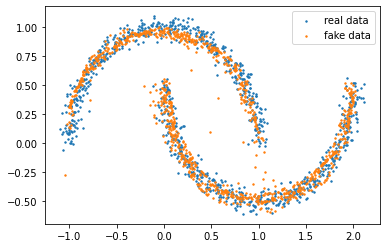

step 10000: discriminator: 1.372e+00, generator: 8.250e-01


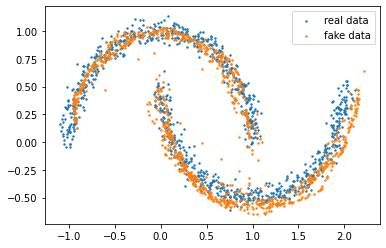

step 11000: discriminator: 1.352e+00, generator: 7.287e-01


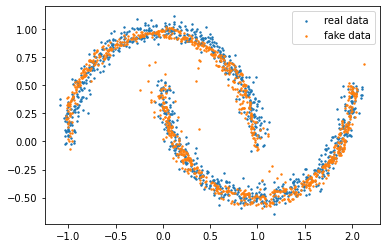

step 12000: discriminator: 1.350e+00, generator: 9.347e-01


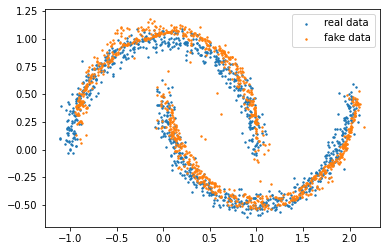

step 13000: discriminator: 1.355e+00, generator: 9.217e-01


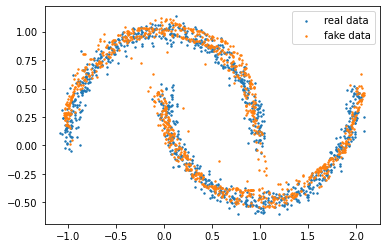

step 14000: discriminator: 1.376e+00, generator: 7.333e-01


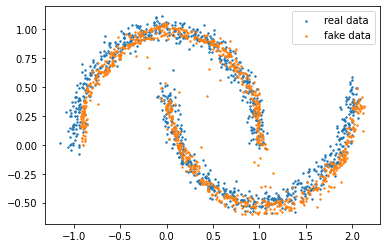

step 15000: discriminator: 1.385e+00, generator: 7.553e-01


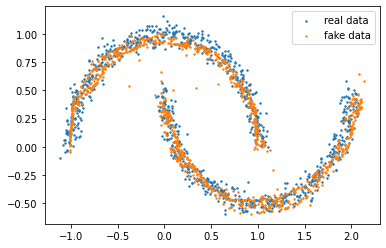

step 16000: discriminator: 1.344e+00, generator: 7.242e-01


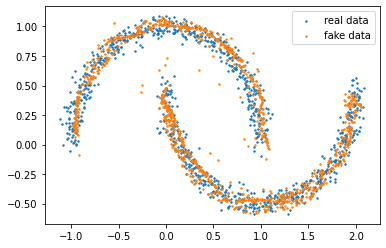

step 17000: discriminator: 1.333e+00, generator: 8.216e-01


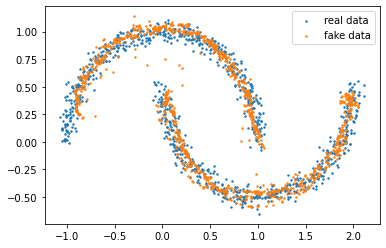

step 18000: discriminator: 1.375e+00, generator: 7.332e-01


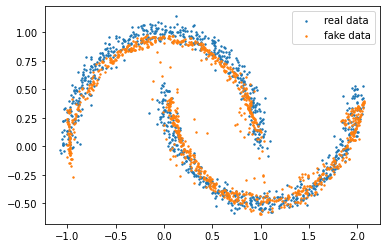

step 19000: discriminator: 1.361e+00, generator: 6.822e-01


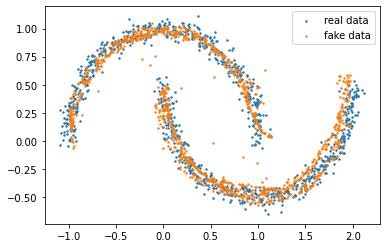

step 20000: discriminator: 1.337e+00, generator: 7.218e-01


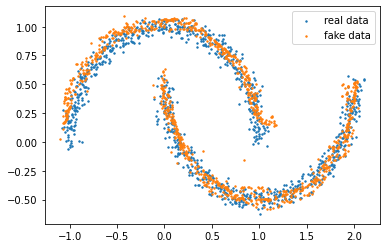

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 4
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Keep track of losses
disc_loss_lst, gen_loss_lst = [], []

generator = Generator([32,32,2]).to(device)
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator([256,128,64,1]).to(device)
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    disc_epoch_loss = []
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN).to(device)
        fake_batch = generator.generate(BATCHLEN, device)
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        fake_pred = discriminator(fake_batch)
        real_pred = discriminator(real_batch)
        disc_loss = -torch.mean(torch.log(real_pred)) - torch.mean(torch.log(1 - fake_pred))
        disc_loss.backward()
        optim_disc.step()
        disc_epoch_loss.append(disc_loss.item())
    disc_loss_lst.append(np.mean(disc_epoch_loss))

    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN, device)
    
    # == COMPUTE THE GENERATOR LOSS HERE
    input_ = discriminator(fake_batch)
    gen_loss = torch.mean(-torch.log(input_))
    gen_loss.backward()
    optim_gen.step()
    gen_loss_lst.append(gen_loss.item())

    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024, device).detach().cpu()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

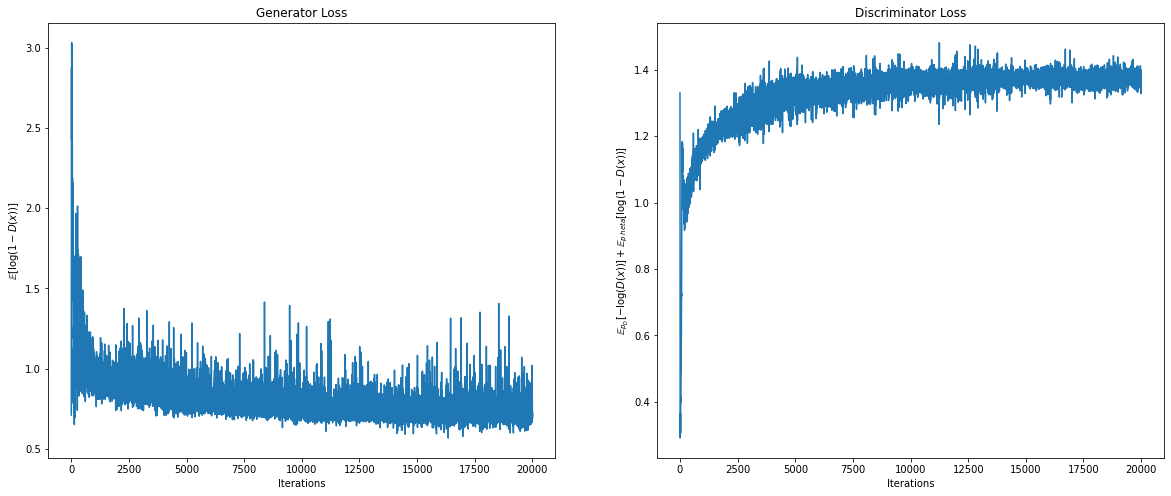

In [ ]:
# Plot training curve
fig, axs = plt.subplots(1,2,figsize=(20,8))

axs[0].set_title("Generator Loss")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("$\mathbb{E}[\log(1-D(x))]$")
axs[0].plot(gen_loss_lst)

axs[1].set_title("Discriminator Loss")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("$\mathbb{E}_{p_D}[-\log(D(x))] + \mathbb{E}_{p_\theta}[\log(1-D(x))]$")
axs[1].plot(disc_loss_lst)

plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> The collapsing behavior of the generator is linked to **the vanishing gradient problem**. Indeed, when too good, the discriminator doesn't provide enough information to the generator in order to be trained. That is, if our discriminator is too good, gradients of $\mathcal{L}_G$ vanish to 0 and training becomes impossible (steps taken in gradient descent are too small). In this case, the generator becomes stuck in its current state and is unable to make progress.

> The following article produces the theoratical results proving the **vanishing gradient problem** in the GAN cost function case: [What is wrong with the GAN cost function ?](https://jonathan-hui.medium.com/gan-what-is-wrong-with-the-gan-cost-function-6f594162ce01).

> **Theorem:** Let $f_\theta$ be a differentiable function that induces a probability distribution $p_\theta$. Let $p_D$ be a real data distribution. Let $D$ be a differentiable discriminator. Let $D^*$ be an optimal discriminator. Then, in specific conditions verified in the GAN context,
$$
\lim_{\lVert D-D^* \rVert ⟶ 0}\lVert \nabla_{\theta} \mathbb{E}_{p_\theta}[\log(1-D(x))] \rVert = 0
$$

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> We first observe that the default architecture of the generator and the discriminator are too simple to produce good results. We thus decide to inspect larger model architectures. For the generator and discriminator, we test for a succession of linear layers of variable depth and width.

> After testing several model configurations, we observed the following results:
* To obtain a satisfying result, the generator can have a simpler architecture than the discriminator. This can probably be explained because of the task we are attempting to solve. A function $f_\theta$ does not need to be too complex to map a gaussian distribution to the moon distribution we attempt to predict. On the contrary, trying to differentiate between generated data and real moon data becomes extremely complex when the generator performs well. Therefore, a complex discriminator is required.
* There is a limit to the depth and width we can use for the discriminator. Indeed, though the change of loss function has solved the **vanishing gradient problem**, if the discriminator is too good in the early stages of training, gradient may explode. Indeed, if $D(x)$ vanishes on generated data, then $-\log(D(x))$ explodes and so does the gradient.
* Similarly to the previous point, using a high training ratio may produce a too good discriminator. In this case, the gradient will also explode.
* We still see a positive effect in using a training ratio superior to $1$ as the discriminator architecture is quite complex. Thus, to make training efficient and make the discriminator relatively good, we must train it for several iterations at each epoch.

> Finally, we obtain our best model when using a generator of depth and width $[2,32,32,2]$, a discriminator of shape $[2,256,128,64,1]$ and a training ratio of $4$.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> We aim to prove the following assertion:
$$
(1) \min_\theta\mathbb{E}_{p_D}\left[ \log p_\theta(x) \right] = \max_\theta \mathbb{E}_{p_D}\left[ \log(\frac{p_D}{p_\theta}) \right] (2)
$$

> *Note:* the minimization and maximization problems are restrained to the space of $\theta$ because they are to be solved by the generative model which learns $\theta$ and leaves $D$ constant.

> We start from equation $(2)$:
$$
\mathbb{E}_{p_D}\left[ \log(\frac{p_D}{p_\theta}) \right] = \mathbb{E}_{p_D}\left[ \log p_D \right] - \mathbb{E}_{p_D}\left[ \log p_\theta \right]
$$

> But $\mathbb{E}_{p_D}\left[ \log p_D \right]$ is constant with regards to $\theta$. Therefore:
$$
\max_\theta \mathbb{E}_{p_D}\left[ \log p_D \right] - \mathbb{E}_{p_D}\left[ \log p_\theta \right] = \max_\theta \left( - \mathbb{E}_{p_D}\left[ \log p_\theta \right] \right)
$$

> Finally, considering $\max_\theta \left( -f(\theta) \right) = \min_\theta f(\theta)$, we obtain the final result:
$$
\max_\theta \mathbb{E}_{p_D}\left[ \log(\frac{p_D}{p_\theta}) \right] = \min_\theta\mathbb{E}_{p_D}\left[ \log p_\theta(x) \right]
$$

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> The issue with not sampling over $p(z)$ during the training process is that it may cause overfitting. Indeed once the models converge, sampling will happen over small regions of the latent space centered around the laws $(q_\phi(.|x_i))_i$ defined by the encoder. The regions excluded by the encoder will then not be trained on by the decoder which could cause results in these regions to be meaningless.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> Let $N_z$ be the dimension of $z$, we compute $D_{KL}(q_\phi(z | x) \| p(z))$,
$$
D_{KL}(q_\phi(z | x) \| p(z)) = \mathbb{E}_{z \sim q_\phi} \left[ \log \left( \frac{q_\phi(z|x)}{p(z)} \right) \right] = \int_z q_\phi(z|x)\log \left( \frac{q_\phi(z|x)}{p(z)} \right)dz
$$
Thus, 
$$
D_{KL}(q_\phi(z | x) \| p(z)) = \int_z q_\phi(z|x)log(q_\phi(z|x))dz - \int_z q_\phi(z|x)log(p(z))dz
$$

> Given the law distributions mentionned above, we have:
$$
\int_z q_\phi(z|x)log(p(z))dz = \int_z \frac{1}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right) \log \left( \frac{1}{(2\pi)^{N_z/2}}\exp \left( -\frac{z^Tz}{2} \right) \right)dz
$$
$$
= -\frac{N_z}{2}\log(2\pi)\underbrace{\int_z\frac{1}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)dz}_\text{$=1$ integrating $\mathcal{N}$ PDF} - \frac{1}{2} \underbrace{\int_z \frac{z^Tz}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)dz}_\text{$\mathcal{N}$ law second order moment $=\mu_\phi(x)^T\mu_\phi(x) + tr(\sigma_\phi^2(x))$}
$$
Thus, we get:
$$
\int_z q_\phi(z|x)log(p(z))dz =-\frac{1}{2} \left( N_z\log(2\pi)+ \mu_\phi(x)^T\mu_\phi(x) + tr(\sigma_\phi(x)^2)  \right)
$$

> Let us now compute:
$$
\int_z q_\phi(z|x)log(q_\phi(z|x))dz = \int_z \frac{1}{(2\pi)^{N_z/2} \underbrace{|\sigma_\phi^2(x)|^{1/2}}_\text{$=|\sigma_\phi(x)|$,$\sigma_\phi(x)$ diagonal}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)\log \left( \frac{1}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right) \right)dz
$$
$$
= -\log((2\pi)^{N_x/2} |\sigma_\phi(x)|)\underbrace{\int_z \frac{1}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right))dz}_\text{$=1$ integrating $\mathcal{N}$ PDF} - \frac{1}{2}\int_z \frac{(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x))}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)dz
$$
Thus,
$$
\int_z q_\phi(z|x)log(q_\phi(z|x))dz = -\log((2\pi)^{N_x/2} |\sigma_\phi(x)|)-\frac{1}{2}\int_z \frac{(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x))}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)dz
$$
Moreover,
$$
\int_z \frac{(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x))}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)dz 
= 
\underbrace{\int_z \frac{z^T\sigma_\phi^2(x)^{-1}z}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)dz}_\text{$=\mathbb{E}[z^T\sigma_\phi^2(x)^{-1}z] = \mathbb{E}[(\sigma_\phi(x)^{-1}z)^T(\sigma_\phi(x)^{-1}z)]$ (because $\sigma_\phi(x)$ is diagonal)}
-
\underbrace{\int_z \frac{z^T}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)dz}_\text{$=\mathbb{E}[z^T]=\mu_\phi(x)^T$}\sigma_\phi^{2}(x)^{-1}\mu_{\phi}(x)
-
\mu_\phi(x)^T\sigma_\phi^{2}(x)^{-1}\underbrace{\int_z \frac{z}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)dz}_\text{$=\mathbb{E}[z]=\mu_\phi(x)$}
+
\mu_\phi(x)\sigma_\phi^{2}(x)^{-1}\mu_\phi(x)^T\underbrace{\int_z \frac{1}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)dz}_\text{$=1$ integrating $\mathcal{N}$ PDF}
$$
Thus,
$$
\int_z \frac{(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x))}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)dz
=
\mathbb{E}[(\sigma_\phi(x)^{-1}z)^T(\sigma_\phi(x)^{-1}z)]-2\mu_\phi(x)^T\sigma_\phi^{2}(x)^{-1}\mu_\phi(x) + \mu_\phi(x)^T\sigma_\phi^{2}(x)^{-1}\mu_\phi(x)
$$

> But, by product of a constant to a Gaussian distribution, $ \sigma_\phi(x)^{-1}z | x \sim \mathcal{N}(\sigma_\phi(x)^{-1}\mu_\phi(x),Id) $, so,
$$
\mathbb{E}[(\sigma_\phi(x)^{-1}z)^T(\sigma_\phi(x)^{-1}z)] = Var((\sigma_\phi(x)^{-1}z)^T) + \mathbb{E}[(\sigma_\phi(x)^{-1}z)^T]\mathbb{E}[(\sigma_\phi(x)^{-1}z)^T]^T = tr(Id) + \mu_\phi(x)^T\sigma_\phi^{2}(x)^{-1}\mu_\phi(x) = N_z + \mu_\phi(x)^T\sigma_\phi^{2}(x)^{-1}\mu_\phi(x)
$$
Thus,
$$
\int_z \frac{(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x))}{(2\pi)^{N_z/2} |\sigma_\phi^2(x)|^{1/2}}\exp \left( -\frac{1}{2}(z-\mu_\phi(x))^T\sigma_\phi^{2}(x)^{-1}(z-\mu_\phi(x)) \right)dz = N_z
$$
And,
$$
\int_z q_\phi(z|x)log(q_\phi(z|x))dz = -\frac{1}{2}\left( N_z\log(2\pi) + \log(|\sigma_\phi^2(x)|) + N_z \right)
$$

> Finally, this gives us the following result,
$$
D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2} \left( \mu_\phi(x)^T\mu_\phi(x) + tr(\sigma_\phi^2(x)) - \log (|\sigma_\phi^2(x)|) - N_z \right)
$$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> Let $N_x$ be the dimension of x and consider $p_\theta(x|z) \sim \mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$,
$$
p_\theta(x|z) = \frac{1}{(2\pi)^{N_x/2}\underbrace{|\sigma_\theta^2(z)|^{1/2}}_\text{$=|\sigma_\theta(z)|$, $\sigma_\theta(x)$ diagonal}}\exp \left( -\frac{1}{2}(x-\mu_\theta(z))^T \sigma_\theta^2(z)^{-1}(x-\mu_\theta(z)) \right)
$$
Thus,
$$
-\log(p_\theta(x|z)) = \frac{1}{2} \left( (x-\mu_\theta(z))^T \sigma_\theta^2(z)^{-1}(x-\mu_\theta(z)) + {N_x}\log(2\pi) + \log(|\sigma^{2}_\theta(z)|) \right)
$$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [40]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        self.module_list = nn.ModuleList()
        self.module_list.append(nn.Linear(2,neurons[0]))
        for i in range(len(neurons[1:])):
            self.module_list.append(nn.Linear(neurons[i],neurons[i+1]))
        self.fc_mu = nn.Linear(neurons[-1], LATENT_N)
        self.fc_logvar = nn.Linear(neurons[-1], LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        for layer in self.module_list:
            x = nn.ReLU()(layer(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        self.module_list = nn.ModuleList()
        self.module_list.append(nn.Linear(LATENT_N,neurons[0]))
        for i in range(1,len(neurons)):
            self.module_list.append(nn.Linear(neurons[i-1],neurons[i]))
        self.fc_mu = nn.Linear(neurons[-1], 2)
        self.fc_logvar = nn.Linear(neurons[-1], 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        for layer in self.module_list:
              z = nn.ReLU()(layer(z))
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen, device):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0).to(device)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 1.315e+01, rec: 1.892e+00


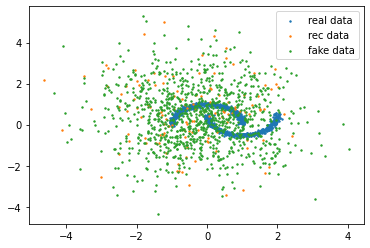

step 1000: KL: 1.111e+00, rec: 8.162e-01


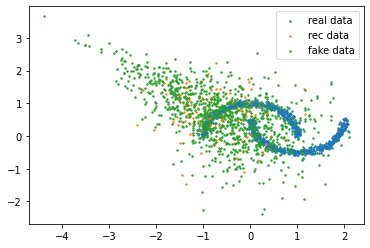

step 2000: KL: 4.731e+00, rec: -8.192e+00


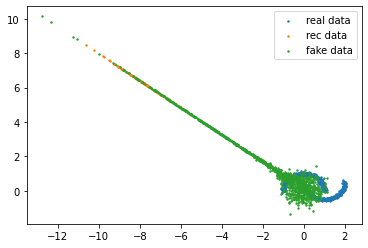

ValueError: ignored

In [41]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128
# Set device
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder([4]).to(device)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder([2]).to(device)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN).to(device)
    
    enc_mu, enc_logvar = encoder(x)
    # COMPUTE THE KL PART OF THE LOSS HERE
    loss_kl = torch.mean(torch.sum(torch.square(enc_mu), dim=1) + torch.sum(torch.exp(enc_logvar), dim=1) - 0.5*torch.log(torch.sum(torch.square(torch.exp(enc_logvar)), dim=1)))
    
    # SAMPLE z FROM q(z|x) HERE
    z = enc_mu + torch.exp(0.5*enc_logvar) * torch.randn_like(enc_logvar)
    
    dec_mu, dec_logvar = decoder(z)
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    # Sample x FROM p(x|z)
    x  = dec_mu + torch.exp(0.5*dec_logvar) * torch.randn_like(dec_logvar)
    distribution = torch.distributions.Normal(dec_mu,torch.exp(0.5*dec_logvar))
    log_prob = distribution.log_prob(x)
    loss_rec = -torch.mean(log_prob)
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach().cpu()
        fake_batch = decoder.generate(1024, device).detach().cpu()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

> (Write your answer here, observe the plots)

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

> Unfortunately, we weren't able to obtain satisfying results with the VAE. We tried tuning several parameters and in particular Encoder/Decoder architecture but nothing seemed to work. We observed a specific behaviour during each training attempt. It seemed like the Decoder would always project the reconstructed and generated data onto a straight line and would also diverge. In an attempt to control this divergence, we tried to limit the variance explosion using activation layers but this never gave satisfying results. The error may also come from a mistake we made in the computation and implementation of loss functions, though we tried to implement them in a more direct way using the distributions module of torch and their log_prob method. Unfortunately, this also gave the same unsatisfying results.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> Consider $f:X \longrightarrow Z$ a bijective mapping so that $f^{-1}(Z)$ and $X$ follow the same law distribution. We aim to justify the identity,
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f \iff p_X(x) = p_Z(z)detJ_f
$$

> The fact that $p_X$ and $p_Z$ are both probability measures impose the following constraints,
$$
\int_x p_X(x)dx = 1 = \int_z p_Z(z)dz
$$
Using the change of variable formula with $z=f(x)$,
$$
\int_x p_Z(f(x))dx \underset{z=f(x),dz=detJ_fdx}{=} \int_z p_Z(z)(defJ_f^{-1})dz
$$
Thus,
$$
\int_x p_Z(f(x))dx = detJ_f^{-1}
$$
And, in general, $p_Z(f)$ does not represent a probability measure on $X$.  We must impose the following normalization term to meet all necessary requirements and justifies the equality,
$$
p_X(x) = p_Z(z)detJ_f
$$

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> First, we rewrite the above equation,
$$
\log(p_X(x)) = \log(p_Z(z)) + \log(defJ_f) \iff \log \left( \frac{p_D}{p_\theta} \right) = \log(detJ_f)
$$
Thus,
$$
KL(p_D||p_G) = \mathbb{E}_{p_D} \left[ \log \left( \frac{p_D}{p_\theta} \right) \right] = \mathbb{E}_{p_D}\left[ \log(detJ_f) \right]
$$

> But $f$ is a deterministic function with regards to the probality space of $Z$. Thus,
$$
KL(p_D||p_G) =  \log(detJ_f)
$$

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> Write $f$ the mapping defined above, consider $s,t$ as known functions, we aim to prove $f$ is invertible. But, $f$ is invertible if and only if it is injective. Therefore, take $x_1,x_2$ such that $f(x_1)=f(x_2)$. We prove $x_1=x_2$. First,
$$
f_{1:d}(x_1) = f_{1:d}(x_2) ⟹ x_{1,1:d} = x_{2,1:d}
$$

> We thus note $x_{1,1:d} = x_{2,1:d} = x_{1:d}$. Then,
$$
f_{d+1:D}(x_1) = f_{d+1:D}(x_2) ⟹ x_{1,d+1:D}\odot \exp(s(x_{1,1:d})) + t(x_{1,1:d}) = x_{2,d+1:D}\odot \exp(s(x_{2,1:d})) + t(x_{2,1:d}) ⟹ x_{1,d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d}) = x_{2,d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d}) ⟹ x_{1,d+1:D}\odot \exp(s(x_{1:d})) = x_{2,d+1:D}\odot \exp(s(x_{1:d})) \underset{\exp(s(x_{1:d})) > 0}{⟹} \frac{x_{1,d+1:D}\odot \exp(s(x_{1:d}))}{\exp(s(x_{1:d}))} = \frac{x_{2,d+1:D}\odot \exp(s(x_{1:d}))}{\exp(s(x_{1:d}))} ⟹ x_{1,d+1:D} = x_{2,d+1:D}
$$
Thus, 
$$
x_{1} = x_{2}
$$
And $f$ is invertible. Moreover, we have an explicit expression of $f^{-1}$,
* $f^{-1}(y)_{1:d} = y_{1:d}$
* $f^{-1}(y)_{d+1:D} = \frac{y_{d+1:D}-t(y_{1:d})}{exp(s(y_{1:d}))}$

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> Define $
\frac{\partial f_{a:b}}{\partial x_{c:d}} = \left( \frac{\partial f_i}{\partial x_j} \right)_{a \leq i \leq b, c \leq j \leq d}$. We have, 
* $f_{1:d}(x) = Id(x_{1:d})$, so $ \frac{\partial f_{1:d}}{\partial x_{1:d}} = I_d $ and $ \frac{\partial f_{1:d}}{\partial x_{d+1:D}} = 0_{D-d,d} $.
* $\forall i \in \left\{ d+1...D \right\}, f_i(x)=x_i * \exp(s(x_{1:d}))_i + t(x_{1:d})_{i} $, so $\frac{\partial f_{d+1:D}}{\partial x_{d+1:D}}=Diag(exp(s(x_{1:d})))$.

> We can then write,
$$
J_f= \left(
   \begin{array}{c|c|c}
      I_d & \frac{\partial f_{d+1:D}}{\partial x_{1:d}} \\
      \hline
      0_{D-d,d} & Diag(exp(s(x_{1:d})))\\ 
   \end{array}
   \right)
$$

> $J_f$ is thus an upper-triangular matrix which has a simple determinant expression,
$$
|J_f| =    \begin{vmatrix}
      I_d & \frac{\partial f_{d+1:D}}{\partial x_{1:d}} \\
      0_{D-d,d} & Diag(exp(s(x_{1:d})))\\ 
   \end{vmatrix} = \prod_{i=1}^{D}J_{f,ii} = \prod_{j=d+1}^{D}exp(s(x_{1:d}))_{j}
$$
Which gives,
$$
|J_f| = exp \left( \sum_{j}s(x_{1:d})_j \right)
$$

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.s = nn.Sequential(nn.Linear(input_size,hidden_size),nn.LeakyReLU(),nn.Linear(hidden_size,hidden_size),nn.LeakyReLU(),nn.Linear(hidden_size,output_size),nn.Tanh())
        self.t = nn.Sequential(nn.Linear(input_size,hidden_size),nn.LeakyReLU(),nn.Linear(hidden_size,hidden_size),nn.LeakyReLU(),nn.Linear(hidden_size,output_size))
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        x_m = self.s(x_m)
        return x_m
        
    def tfun(self, x_m):
        x_m = self.t(x_m)
        return x_m
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        s_out = self.sfun(y_m)
        t_out = self.tfun(y_m)
        y = y_m + (1-self.mask)*torch.div(y-t_out,torch.exp(s_out))
        return y

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.022013
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.039352
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.051270
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.054506
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.054525
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.055179
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.055875
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.057129
====> Epoch: 1 Average train loss: -0.0491


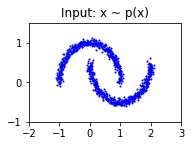

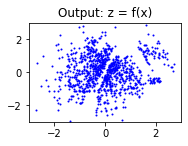

====> Test loss: -0.0587


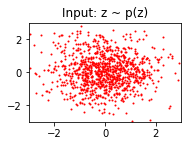

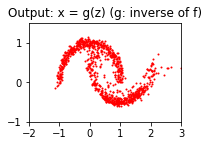

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.056533
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.058089
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.056517
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.057438
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.059006
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.058464
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.058158
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.058517
====> Epoch: 2 Average train loss: -0.0582


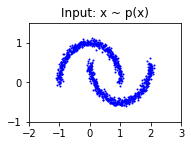

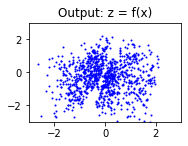

====> Test loss: -0.0598


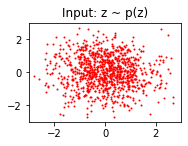

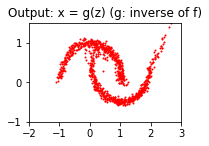

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.058793
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.058924
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.059263
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.059342
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.059728
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.059038
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.059202
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.058735
====> Epoch: 3 Average train loss: -0.0592


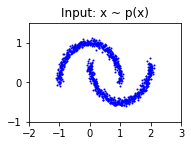

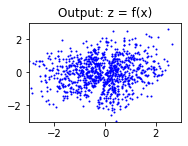

====> Test loss: -0.0605


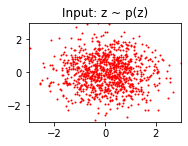

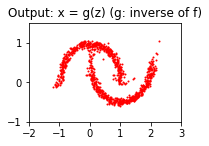

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.058196
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.059261
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.058634
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.059365
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.059845
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.059616
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.058248
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.060302
====> Epoch: 4 Average train loss: -0.0595


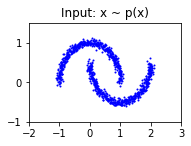

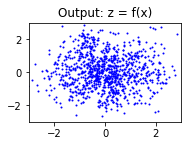

====> Test loss: -0.0608


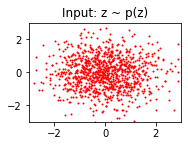

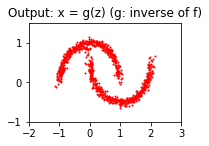

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.058945
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.060156
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.059699
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.058902
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.059394
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.059863
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.058256
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.059549
====> Epoch: 5 Average train loss: -0.0596


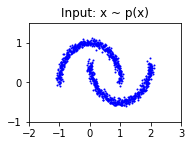

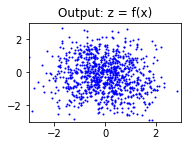

====> Test loss: -0.0609


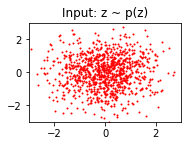

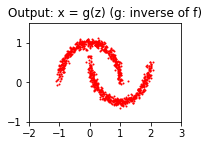

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.059729
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.060270
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.061070
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.058877
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.059274
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.060159
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.059495
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.058785
====> Epoch: 6 Average train loss: -0.0596


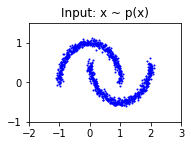

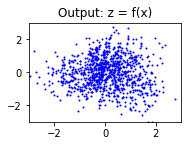

====> Test loss: -0.0608


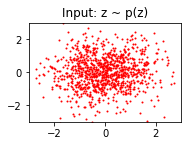

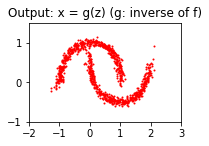

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.059434
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.059833
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.060528
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.060149
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.061060
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.058543
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.059312
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.059431
====> Epoch: 7 Average train loss: -0.0597


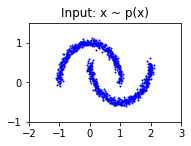

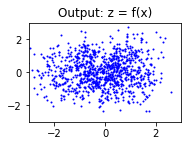

====> Test loss: -0.0609


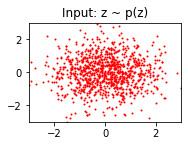

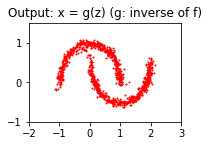

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.059682
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.059482
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059857
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.059920
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059349
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.060222
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.059573
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.059853
====> Epoch: 8 Average train loss: -0.0597


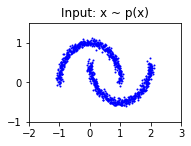

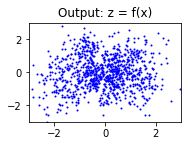

====> Test loss: -0.0608


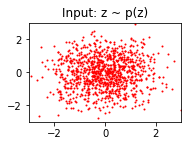

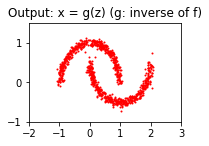

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.059548
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.059918
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.058775
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.058436
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.059340
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.060158
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059715
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.059160
====> Epoch: 9 Average train loss: -0.0597


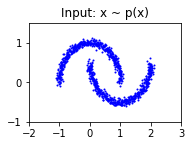

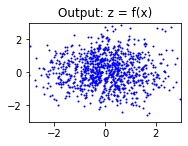

====> Test loss: -0.0610


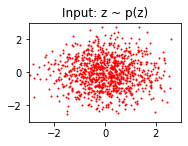

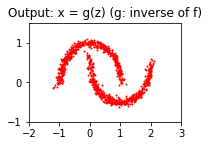

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.059718
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.058838
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059619
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.060678
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.059773
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.060214
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.058729
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.059970
====> Epoch: 10 Average train loss: -0.0598


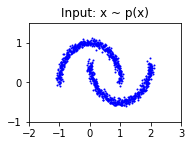

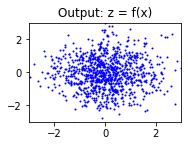

====> Test loss: -0.0612


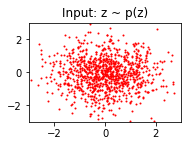

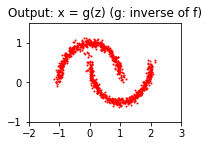

'94.56s'

<Figure size 432x288 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> The mapping function $f$ used in Normalizing flows requires strong assumptions on its regularity (invertible and differentiable with a tractable determinant) and $f^{-1}$ is, in general, also a smooth function. Therefore, the image of a normal distribution, which is "smooth" by $f^{-1}$ will also be "smooth". At least, its image will not be discontinuous. Thus, $f^{-1}$ will struggle to map a normal distribution into several distinct clusters.

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

> First, there is a clear difference in training between the 3 models. While GANs and VAEs struggle to converge and face many problems in there training process (e.g. vanishing gradient and mode collapse for GANs), Normalizing Flows converge more easily. Obtaining good results for GANs and VAEs required important parameter tuning, unlike Normalizing Flows which converged immediately.

> Second, in the case of a simple problem like generating moon data, all three models were extremely fast to converge, when trained with correct parameters. In more complex problems, this does not seem to be the case. [A Comparative Review of Generative Models](https://arxiv.org/pdf/2103.04922.pdf) makes a comparison of the 3 models in a more complex case: generating data from the CIFAR-10 dataset. In this context, Normalizing Flows took between 2 to 5 days to train while GANs and VAEs took less than half a day.

> Third, unlike VAEs and Normalizing Flows, GANs do not make any assumption on the distribution of real data. This offers a more general framework for data generation. This being said, Gaussian Mixture models in the case of VAEs are extremely general and, unless real data is extremely disordered, it can be satisfyingly well represented. Normalizing Flows probably suffer from the largest constraints on distribution modeling. Having to use invertible functions whose gradients are feasibly computable may be constraining in the case of more complex problems and, in particular, for image generation.

> Finally, one can mention the complexity in loss functions. While losses for GANs and Normalizing flows are quite straight forward, the expression of the loss for VAEs is quite complicated. Moreover, it can be explicitly expressed in the reduced case of Gaussian Mixture Models with a Gaussian prior but not in a general setting. This leaves less modeling opportunities for VAEs compared to the other two models. 